In [1]:
from abtem import __version__

from abtem import *
from abtem.waves import FresnelPropagator, Waves
from ase.io import read

from abtem.visualize.interactive.artists import ImageArtist, AtomsArtist
from abtem.visualize.interactive.tools import SelectPositionTool1d

import numpy as np
import matplotlib.pyplot as plt
from abtem.visualize.interactive.canvas import Canvas

from ase import Atoms
from tqdm.auto import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
from traitlets import link

from ase.spacegroup import crystal

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

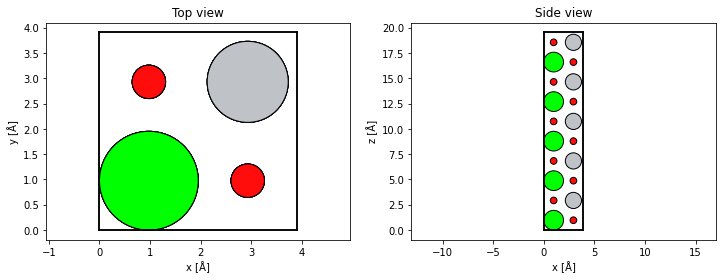

In [49]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
atoms = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 1))

atoms *= (1, 1, 5)
atoms.center()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');

In [3]:
potential = Potential(atoms, sampling=.02, slice_thickness=.2, projection='infinite', parametrization='kirkland')

probe = Probe(energy=120e3, semiangle_cutoff=30)
probe.match_grid(potential)

planewave = PlaneWave(energy=300e3) # uncomment of plane wave
planewave.match_grid(potential) # uncomment of plane wave

potential = potential.build()

In [4]:
def calculate_wave3d(wave):
    wave3d = Waves(array=np.zeros((len(potential) // save_every,) + wave.gpts, dtype=np.complex64), 
                   extent=wave.extent, energy=wave.energy)

    j = 0
    for i, potential_slice in enumerate(potential):

        potential_slice.transmit(wave)
        propagator.propagate(wave, potential_slice.thickness)

        if (i % save_every) == 0:
            wave3d.array[j] = wave.array
            j += 1
    
    return wave3d

In [5]:
save_every = 1

propagator = FresnelPropagator()

probe_position = atoms[2].position[:2] # place probe on atom number 2
wave = probe.build(probe_position)
probe_on_column_wave3d = calculate_wave3d(wave)

probe_position = atoms[2].position[:2] - .3
wave = probe.build(probe_position)
probe_off_column_wave3d = calculate_wave3d(wave)

wave = planewave.build() # uncomment for plane wave
plane_wave3d = calculate_wave3d(wave)

In [6]:
#wave3d.write('3d_wavefunction.hdf5')

In [7]:
#wave3d = Waves.read('3d_wavefunction.hdf5')

In [50]:
canvas1 = Canvas(width=420, fig_margin={'top':20, 'bottom':40, 'left':50, 'right':20})
canvas2 = Canvas(width=200, fig_margin={'top':20, 'bottom':40, 'left':50, 'right':20}, lock_scale=False)

xy_artist = ImageArtist()
xz_artist = ImageArtist()

xy_tool = SelectPositionTool1d(image_artist=xy_artist, marker=True)
xz_tool = SelectPositionTool1d(image_artist=xz_artist, marker=True, direction='y')

initial_wave_dropdown = widgets.Dropdown(description='Initial wave', 
                                         options=['Plane', 'Probe (on column)', 
                                                  'Probe (off column)'], value='Plane')

atoms_artist_xy = AtomsArtist(scale=5)
atoms_artist_xy.atoms = atoms

atoms_artist_xz = AtomsArtist(scale=2, direction='xz')
atoms_artist_xz.atoms = atoms

canvas1.artists = {'image': xy_artist, 'atoms':atoms_artist_xy}
canvas2.artists = {'image': xz_artist, 'atoms':atoms_artist_xz}


def get_wave3d():
    if initial_wave_dropdown.value == 'Plane':
        return plane_wave3d
    elif initial_wave_dropdown.value == 'Probe (on column)':
        return probe_on_column_wave3d
    else:
        return probe_off_column_wave3d
    
def update_xy(*args):
    wave3d = get_wave3d()
    
    i = int(np.round(xz_tool.position / potential.thickness * wave3d.array.shape[0]))
    i = np.clip(i, 0, wave3d.array.shape[0] - 1)
    xy_artist.image = wave3d[i].intensity().array
    
    xy_artist.extent = [(0,wave3d.extent[0]),(0,wave3d.extent[1])]
    xz_artist.extent = [(0,wave3d.extent[0]),(0,potential.thickness)]

def update_xz(*args):
    wave3d = get_wave3d()
    
    i = int(np.round(xy_tool.position / potential.extent[-1] * wave3d.array.shape[-1]))
    i = np.clip(i, 0, wave3d.array.shape[-1] - 1)
    xz_artist.image = np.abs(wave3d.array[:, :, i]).T ** 2
    
    xy_artist.extent = [(0,wave3d.extent[0]),(0,wave3d.extent[1])]
    xz_artist.extent = [(0,wave3d.extent[0]),(0,potential.thickness)]

xy_artist.extent = [(0,1),(0,1)]
xz_artist.extent = [(0,1),(0,1)]

    

update_xy()
update_xz()

canvas2.y_scale.reverse =True

xy_tool.activate(canvas1)
xz_tool.activate(canvas2)

xz_tool.observe(update_xy, 'position')
xy_tool.observe(update_xz, 'position')

canvas1.adjust_limits_to_artists()
canvas2.adjust_limits_to_artists()

xy_tool.position = 3
xz_tool.position = 6

canvas1.x_label = 'x [Å]'
canvas1.y_label = 'y [Å]'

canvas2.x_label = 'y [Å]'
canvas2.y_label = 'z [Å]'

autoadjust_button = widgets.ToggleButton(description='Autoadjust colorscale', value=True)

overlay_atoms_button = widgets.ToggleButton(description='Overlay atoms', value=True)

link((overlay_atoms_button, 'value'), (atoms_artist_xz._scatter_artist, 'visible'))
link((overlay_atoms_button, 'value'), (atoms_artist_xy._scatter_artist, 'visible'))

link((autoadjust_button, 'value'), (xy_artist, 'autoadjust_colorscale'))
link((autoadjust_button, 'value'), (xz_artist, 'autoadjust_colorscale'))


autoadjust_button.observe(update_xy, 'value')
autoadjust_button.observe(update_xz, 'value')

initial_wave_dropdown.observe(update_xy, 'value')
initial_wave_dropdown.observe(update_xz, 'value')

In [51]:
widgets_box = widgets.VBox([initial_wave_dropdown, 
                            widgets.HBox([autoadjust_button, overlay_atoms_button])])

canvases = widgets.HBox([canvas1.widget, canvas2.widget])

widgets.VBox([canvases, widgets_box])